# ADF for binary logistic regression

In [1]:
import os
import jax
# os.environ["TPU_MESH_CONTROLLER_ADDRESS"] = ""
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters
from jax import random
import blackjax.rwmh as mh

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (5, 3)

In [4]:
def sigmoid(z): return jnp.exp(z) / (1 + jnp.exp(z))
def log_sigmoid(z): return z - jnp.log(1 + jnp.exp(z))

def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

## The data

In [5]:
n_datapoints = 50
m = 2
X, rows, cols = make_biclusters((n_datapoints, m), 2, noise=0.6, random_state=3141, minval=-4, maxval=4)
# whether datapoints belong to class 1
y = rows[0] * 1.0

Phi = jnp.c_[jnp.ones(n_datapoints)[:, None], X]
N, M = Phi.shape

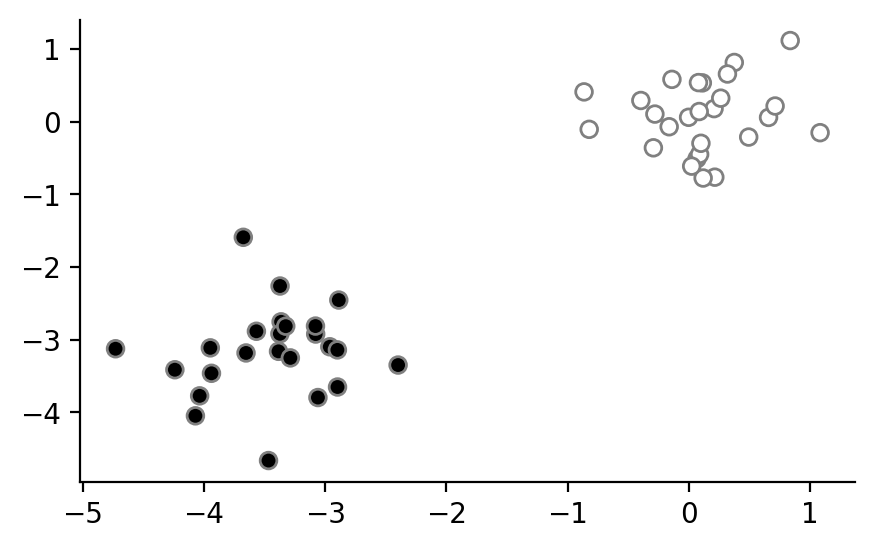

In [29]:
colors = ["black" if el else "white" for el in y]
plt.scatter(*X.T, edgecolors="gray", c=colors)
plt.show()

In [61]:
# Data to plot the predictions
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1
step = 0.1
Xspace = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
_, nx, ny = Xspace.shape

Phispace = jnp.concatenate([jnp.ones((1, nx, ny)), Xspace])

## MCMC Sampling

In [31]:
key = random.PRNGKey(314)
init_noise = 1.0
w0 = random.multivariate_normal(key, jnp.zeros(M), jnp.eye(M) * init_noise)

In [32]:
alpha = 1.0

# Phi: array(N, M)
# w: array(M,)
# y: array(N,)
# (M=3)
def E(w):
    an = Phi @ w
    log_an = log_sigmoid(an)
    log_likelihood_term = y * log_an + (1 - y) * jnp.log1p(-sigmoid(an))
    prior_term = alpha * w @ w / 2

    return prior_term - log_likelihood_term.sum()

In [33]:
sigma_mcmc = 0.8
initial_state = mh.new_state(w0, E)

mcmc_kernel = mh.kernel(E, jnp.ones(M) * sigma_mcmc)
mcmc_kernel = jax.jit(mcmc_kernel)

n_samples = 5_000
key_init = jax.random.PRNGKey(0)
states = inference_loop(key_init, mcmc_kernel, initial_state, n_samples)

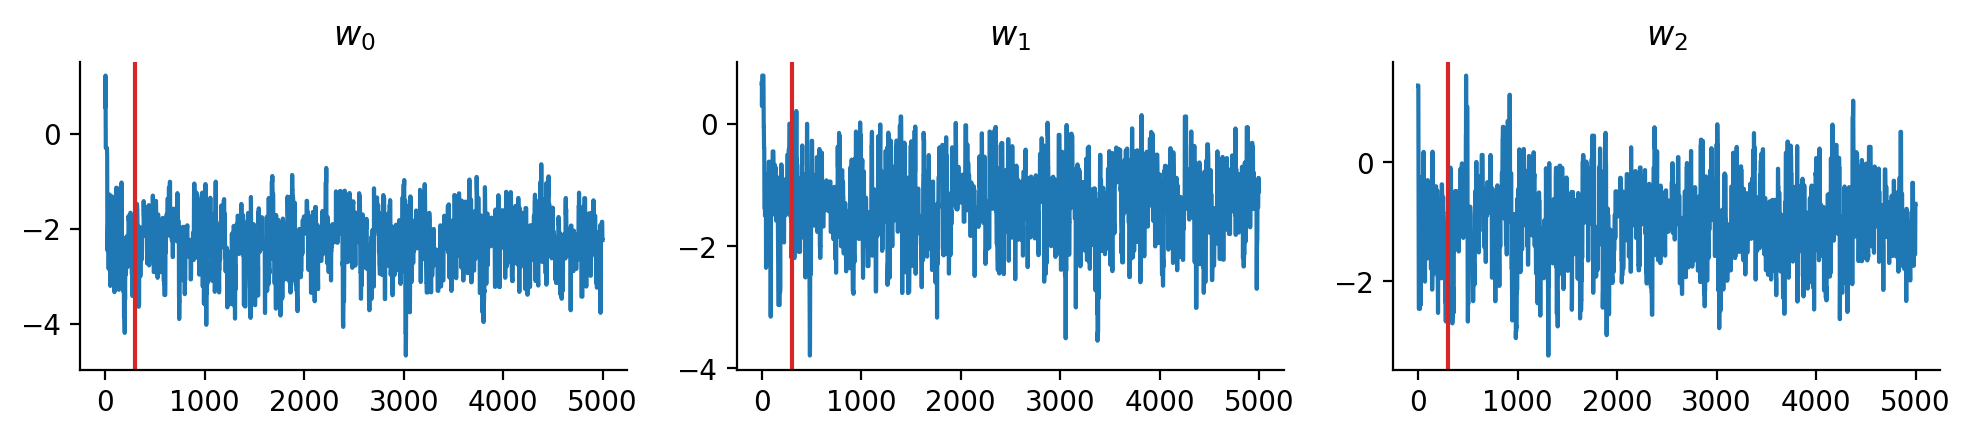

In [34]:
burnin = 300

fig, ax = plt.subplots(1, M, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title(f"$w_{i}$")
    axi.axvline(x=burnin, c="tab:red")
plt.show()

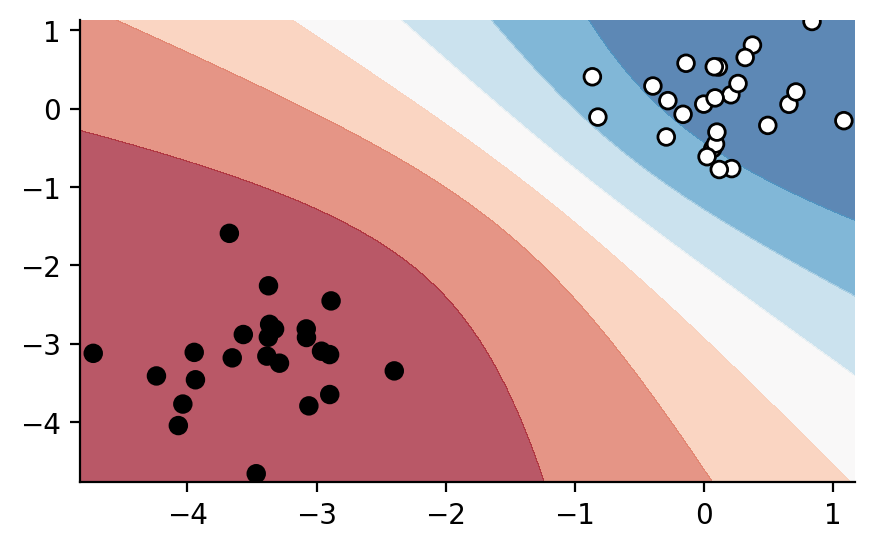

In [36]:
chains = states.position[burnin:, :]
nsamp, _ = chains.shape

Z_mcmc = sigmoid(jnp.einsum("mij,sm->sij", Phispace, chains))
Z_mcmc = Z_mcmc.mean(axis=0)

plt.contourf(*Xspace, Z_mcmc, cmap="RdBu_r", alpha=0.7)
plt.scatter(*X.T, c=colors, edgecolors="black")
plt.show()

## Laplace approximation

In [37]:
from jax.scipy.optimize import minimize
res = minimize(lambda x: E(x) / len(y), w0, method="BFGS")
w_map = res.x

In [38]:
SN = jax.hessian(E)(w_map)
SN

DeviceArray([[ 3.64772156, -1.3727683 , -1.31737804],
             [-1.3727683 ,  5.51035955,  3.52866075],
             [-1.31737804,  3.52866075,  4.78343969]], dtype=float64)

In [39]:
y_map = sigmoid(Phi @ w_map)
SN_exact = alpha * jnp.eye(M) + jnp.einsum("n,n,nm,nk->mk", y_map, 1 - y_map, Phi, Phi)
SN_exact

DeviceArray([[ 3.64772156, -1.3727683 , -1.31737804],
             [-1.3727683 ,  5.51035955,  3.52866075],
             [-1.31737804,  3.52866075,  4.78343969]], dtype=float64)

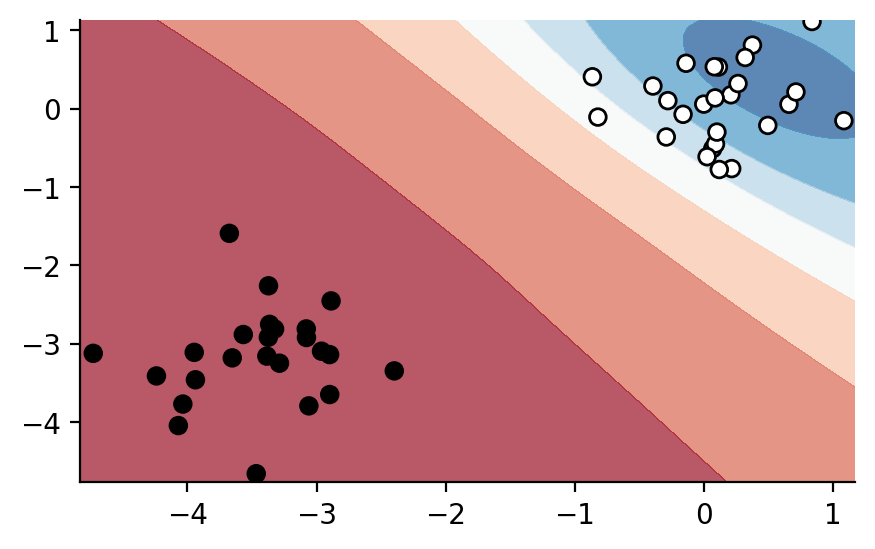

In [40]:
laplace_samples = random.multivariate_normal(key, w_map, SN, (5000,))

Z_laplace = sigmoid(jnp.einsum("mij,sm->sij", Phispace, laplace_samples))
Z_laplace = Z_laplace.mean(axis=0)

plt.contourf(*Xspace, Z_laplace, cmap="RdBu_r", alpha=0.7)
plt.scatter(*X.T, c=colors, edgecolors="black")
plt.show()

## Assumed Density Filtering (ADF)

In [42]:
# !pip install jax_cosmo
from jax_cosmo.scipy import integrate
from jax.scipy.stats import norm
from functools import partial

In [146]:
def sigmoid(z): return jnp.exp(z) / (1 + jnp.exp(z))
def log_sigmoid(z): return z - jnp.log1p(jnp.exp(z))

def Zt_func(eta, y, mu, v):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)
    
    return jnp.exp(log_term)

def mt_func(eta, y, mu, v, Zt):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)
    
    return eta * jnp.exp(log_term) / Zt

def vt_func(eta, y, mu, v, Zt):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)
    
    return eta ** 2 * jnp.exp(log_term) / Zt

def var_t_func(eta, y, mu, v, Zt, mean_t):
    log_term = y * log_sigmoid(eta) + (1 - y) * jnp.log1p(-sigmoid(eta))
    log_term = log_term + norm.logpdf(eta, mu, v)
    
    return (eta - mean_t) ** 2 * jnp.exp(log_term) / Zt

def adf_step(state, xs, *, q, lbound, ubound):
    mu_t, tau_t = state
    Phi_t, y_t = xs
    
    mu_t_cond = mu_t
    tau_t_cond = tau_t + q

    # prior predictive distribution
    m_t_cond = (Phi_t * mu_t_cond).sum()
    v_t_cond = (Phi_t ** 2 * tau_t_cond).sum()

    v_t_cond_sqrt = jnp.sqrt(v_t_cond)

    Zt = integrate.romb(lambda eta: Zt_func(eta, y_t, m_t_cond, v_t_cond_sqrt), lbound, ubound)

    mt = integrate.romb(lambda eta: mt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)
    
    vt = integrate.romb(lambda eta: vt_func(eta, y_t, m_t_cond, v_t_cond_sqrt, Zt), lbound, ubound)
    vt = vt - mt ** 2
    
    delta_m = mt - m_t_cond
    delta_v = vt - v_t_cond

    a = Phi_t * tau_t_cond / (Phi_t ** 2 * tau_t_cond).sum()
    mu_t = mu_t_cond + a * delta_m
    tau_t = tau_t_cond + a ** 2 * delta_v
    
    return (mu_t, tau_t), (mu_t, tau_t)

In [147]:
# prior variance
q = 0.0
lbound, ubound = -20.0, 20.0
mu_t = jnp.zeros(M)
tau_t = jnp.ones(M) * 1.0

init_state = (mu_t, tau_t)
xs = (Phi, y)

adf_loop = partial(adf_step, q=q, lbound=lbound, ubound=ubound)

In [148]:
%%time
(mu_t_adf, tau_t), (mu_t_hist, tau_t_hist) = jax.lax.scan(adf_loop, init_state, xs)

CPU times: user 2.12 s, sys: 0 ns, total: 2.12 s
Wall time: 2.11 s


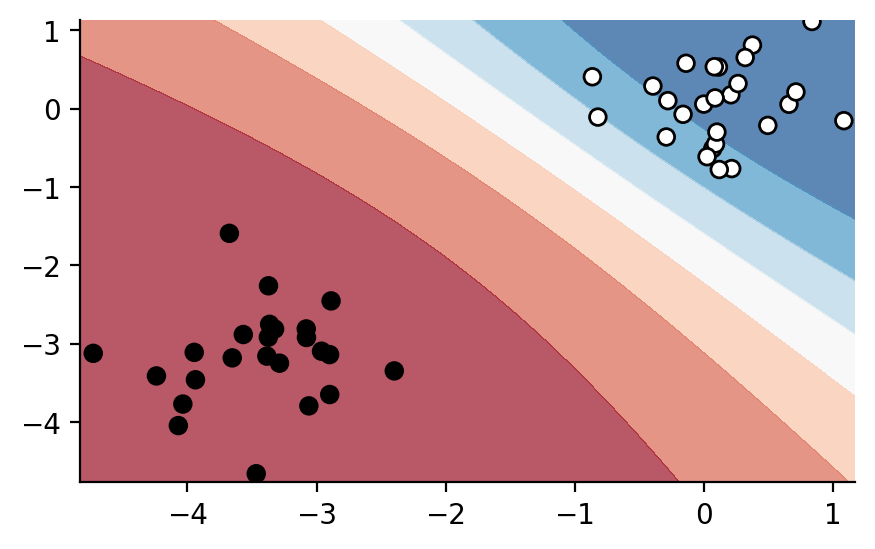

In [150]:
key = random.PRNGKey(314)
adf_samples = random.multivariate_normal(key, mu_t_adf, jnp.diag(tau_t), (5000,))

Z_adf = sigmoid(jnp.einsum("mij,sm->sij", Phispace, adf_samples))
Z_adf = Z_adf.mean(axis=0)

plt.contourf(*Xspace, Z_adf, cmap="RdBu_r", alpha=0.7)
plt.scatter(*X.T, c=colors, edgecolors="black")
plt.show()

# Extended Kalman Filter

In [278]:
def sigmoid(x): return jnp.exp(x) / (1 + jnp.exp(x))
d_sigmoid = jax.grad(sigmoid)

mu_t = jnp.zeros(M)
P_t = jnp.eye(M) * 2.0

def ekf_logistic_step(state, xs):
    x, y = xs
    mu_t, P_t = state
    
    P_t = P_t - P_t @ x[:, None] @ x[None, :] @ P_t / (1 / d_sigmoid(x @ mu_t) + x @ P_t @ x)
    mu_t = mu_t + (P_t @ x) * (y - sigmoid(x @ mu_t))
    
    return (mu_t, P_t), (mu_t, P_t)

init_state = (mu_t, P_t)
obs = (Phi, y)
(mu_t_ekf, P_t), (mu_ekf_hist, P_ekf_hist) = jax.lax.scan(ekf_logistic_step, init_state, obs)
P_ekf_hist_diag = jnp.diagonal(P_ekf_hist, axis1=1, axis2=2)

In [279]:
mu_t_ekf

DeviceArray([-2.18489519, -1.07537177, -0.67506044], dtype=float64)

In [280]:
# Laplace estimatioin
w_map

DeviceArray([-2.19088699, -1.09777736, -0.87689145], dtype=float64)

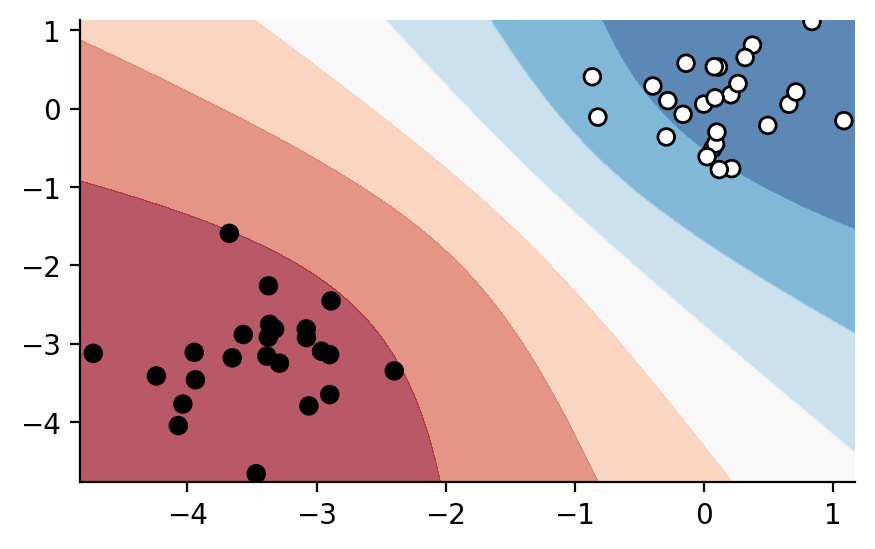

In [281]:
key = random.PRNGKey(314)
ekf_samples = random.multivariate_normal(key, mu_t_ekf, P_t, (5000,))

Z_ekf = sigmoid(jnp.einsum("mij,sm->sij", Phispace, ekf_samples))
Z_ekf = Z_ekf.mean(axis=0)

plt.contourf(*Xspace, Z_ekf, cmap="RdBu_r", alpha=0.7)
plt.scatter(*X.T, c=colors, edgecolors="black")
plt.show()

----


# Full comparisson

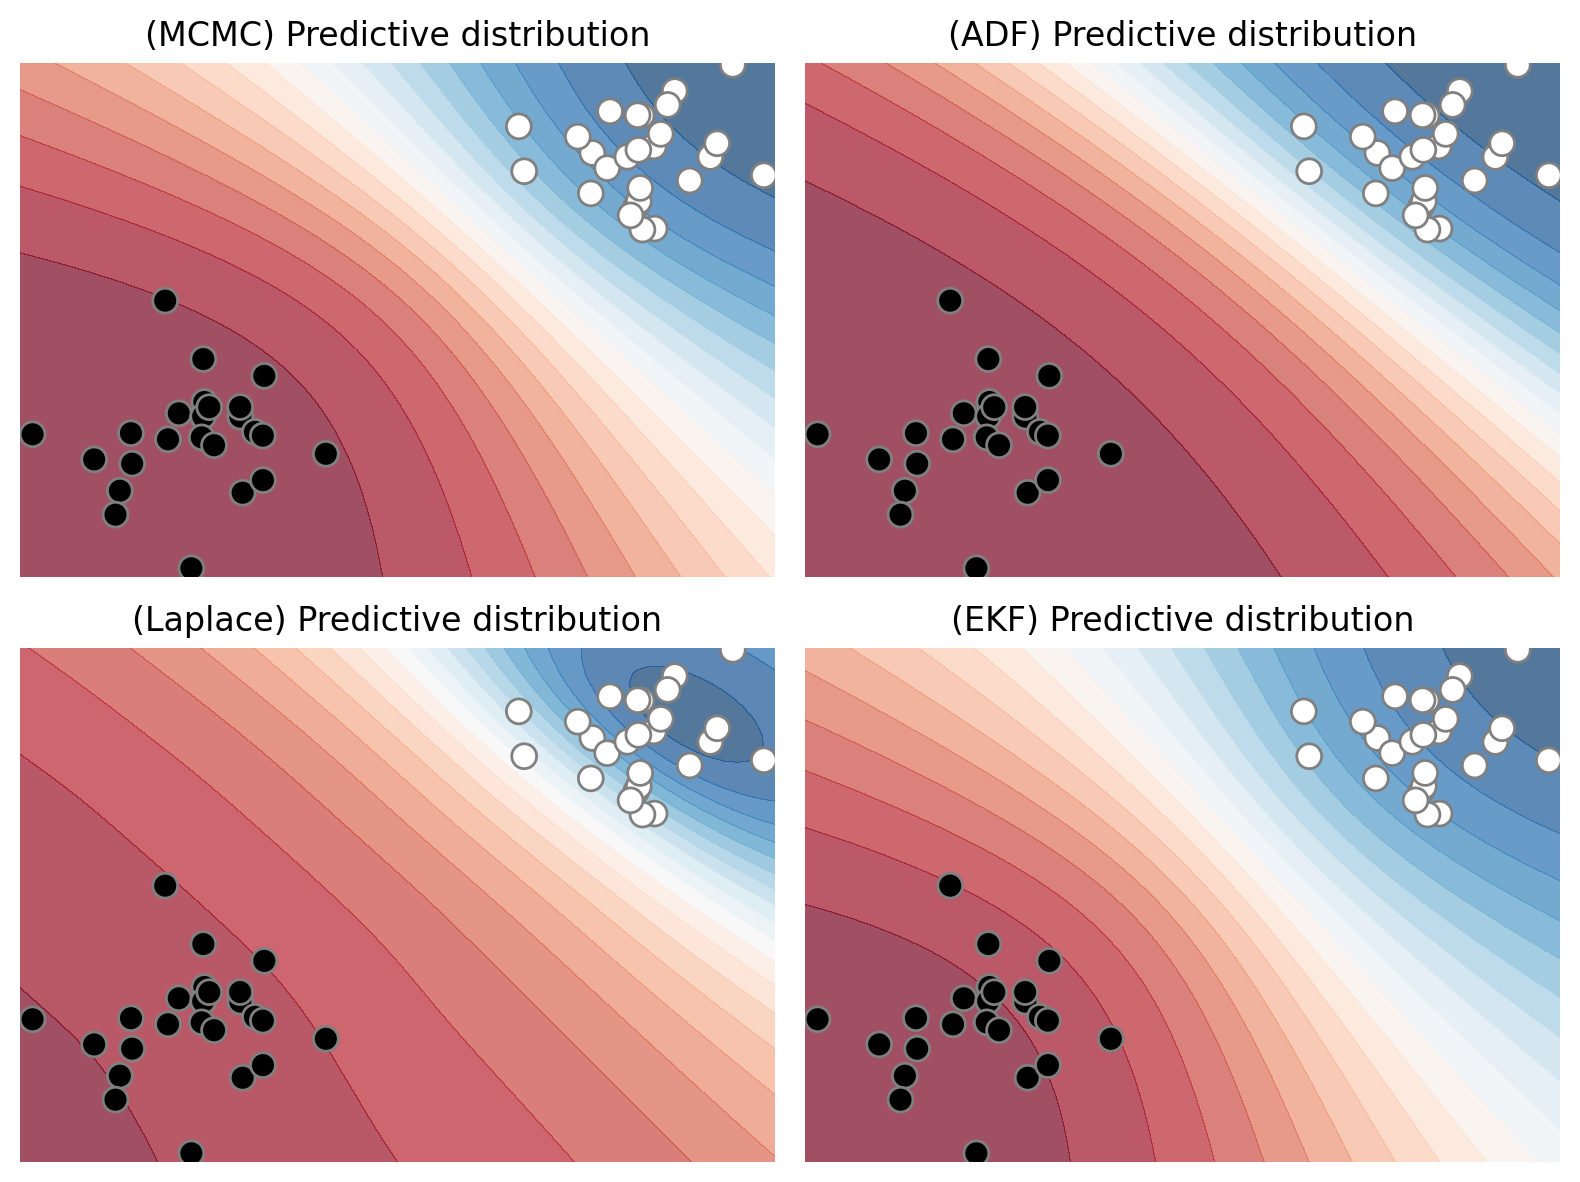

In [282]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.ravel()

ax[0].contourf(*Xspace, Z_mcmc, cmap="RdBu_r", alpha=0.7, levels=20)
ax[0].scatter(*X.T, c=colors, edgecolors="gray", s=80)
ax[0].set_title("(MCMC) Predictive distribution")

ax[1].contourf(*Xspace, Z_adf, cmap="RdBu_r", alpha=0.7, levels=20)
ax[1].scatter(*X.T, c=colors, edgecolors="gray", s=80)
ax[1].set_title("(ADF) Predictive distribution")

ax[2].contourf(*Xspace, Z_laplace, cmap="RdBu_r", alpha=0.7, levels=20)
ax[2].scatter(*X.T, c=colors, edgecolors="gray", s=80)
ax[2].set_title("(Laplace) Predictive distribution")

ax[3].contourf(*Xspace, Z_ekf, cmap="RdBu_r", alpha=0.7, levels=20)
ax[3].scatter(*X.T, c=colors, edgecolors="gray", s=80)
ax[3].set_title("(EKF) Predictive distribution")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[3].axis("off")

plt.tight_layout()
plt.show()

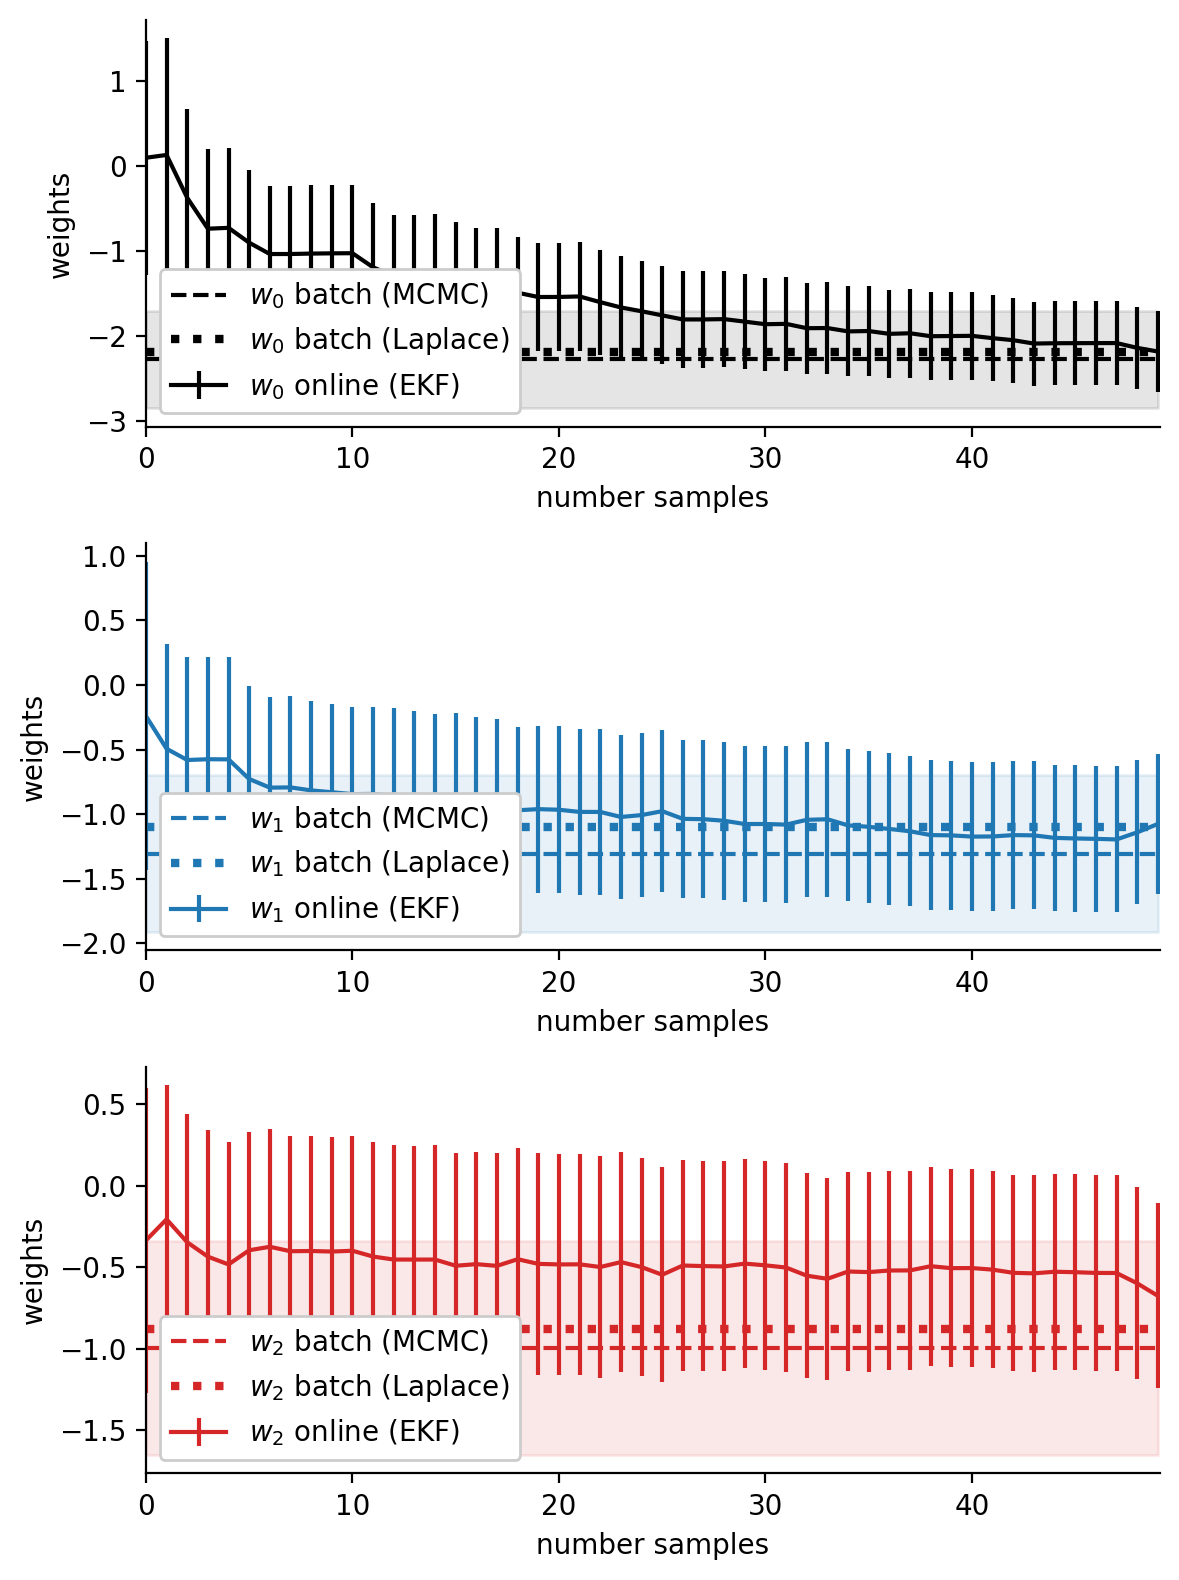

In [283]:
w_batch_all = chains.mean(axis=0)
w_batch_laplace_all = w_map
w_batch_std_all = chains.std(axis=0)
timesteps = jnp.arange(n_datapoints)

lcolors = ["black", "tab:blue", "tab:red"]

fig, ax = plt.subplots(3, 1, figsize=(6, 8))
elements = zip(mu_ekf_hist.T, P_ekf_hist_diag.T, w_batch_all, w_batch_std_all, w_batch_laplace_all, lcolors)

for i, (w_online, w_err_online, w_batch, w_batch_err, w_batch_laplace, c) in enumerate(elements):
    ax[i].errorbar(timesteps, w_online, jnp.sqrt(w_err_online), c=c, label=f"$w_{i}$ online (EKF)")
    ax[i].axhline(y=w_batch, c=lcolors[i], linestyle="--", label=f"$w_{i}$ batch (MCMC)")
    ax[i].axhline(y=w_batch_laplace, c=lcolors[i], linestyle="dotted",
                  label=f"$w_{i}$ batch (Laplace)", linewidth=3)
    ax[i].fill_between(timesteps, w_batch - w_batch_err, w_batch + w_batch_err, color=c, alpha=0.1)

    ax[i].legend(framealpha=1, loc="lower left")
    ax[i].set_xlim(0, n_datapoints - 0.9)
    ax[i].set_xlabel("number samples")
    ax[i].set_ylabel("weights")
plt.tight_layout()
plt.show()

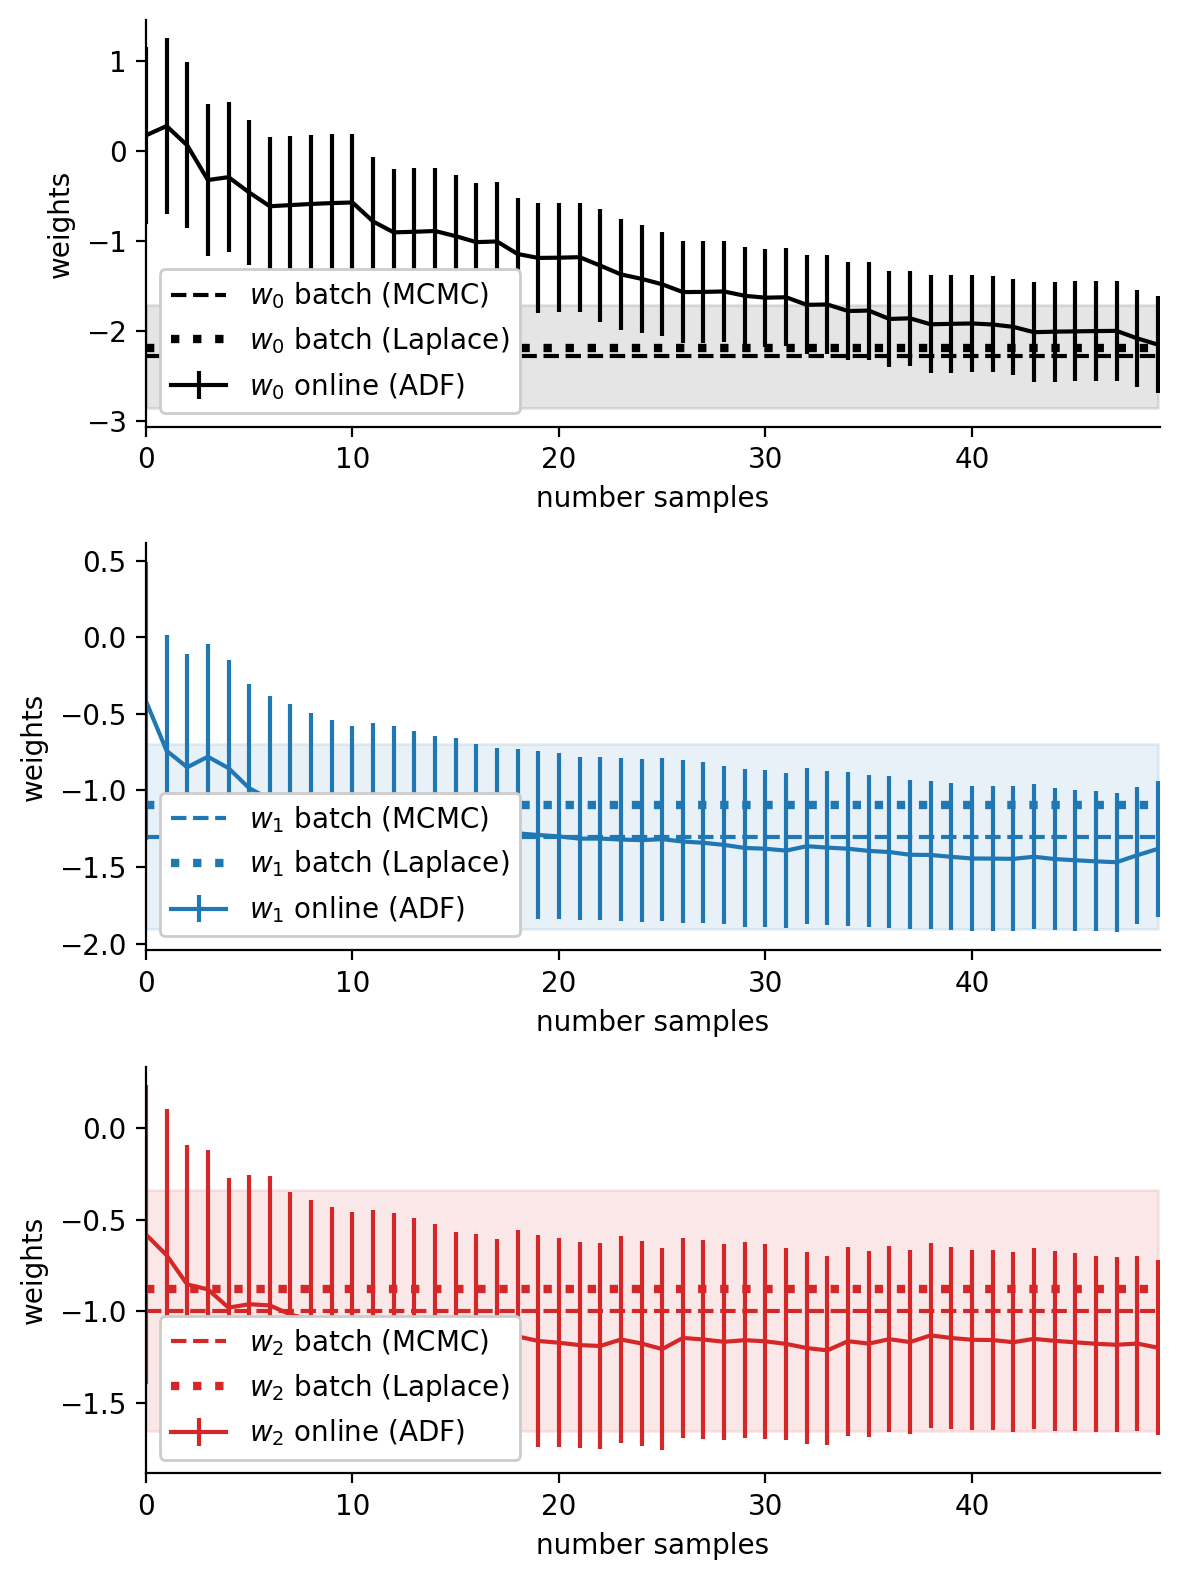

In [276]:
w_batch_all = chains.mean(axis=0)
w_batch_laplace_all = w_map
w_batch_std_all = chains.std(axis=0)
timesteps = jnp.arange(n_datapoints)

lcolors = ["black", "tab:blue", "tab:red"]

fig, ax = plt.subplots(3, 1, figsize=(6, 8))
elements = zip(mu_t_hist.T, tau_t_hist.T, w_batch_all, w_batch_std_all, w_batch_laplace_all, lcolors)

for i, (w_online, w_err_online, w_batch, w_batch_err, w_batch_laplace, c) in enumerate(elements):
    ax[i].errorbar(timesteps, w_online, jnp.sqrt(w_err_online), c=c, label=f"$w_{i}$ online (ADF)")
    ax[i].axhline(y=w_batch, c=lcolors[i], linestyle="--", label=f"$w_{i}$ batch (MCMC)")
    ax[i].axhline(y=w_batch_laplace, c=lcolors[i], linestyle="dotted",
                  label=f"$w_{i}$ batch (Laplace)", linewidth=3)
    ax[i].fill_between(timesteps, w_batch - w_batch_err, w_batch + w_batch_err, color=c, alpha=0.1)

    ax[i].legend(framealpha=1, loc="lower left")
    ax[i].set_xlim(0, n_datapoints - 0.9)
    ax[i].set_xlabel("number samples")
    ax[i].set_ylabel("weights")
plt.tight_layout()
plt.show()

In [284]:
# MCMC / Laplace / ADF / EKF
jnp.stack([w_batch_all, w_batch_laplace_all, mu_t_adf, mu_t_ekf])

DeviceArray([[-2.27910286, -1.30405967, -0.99552648],
             [-2.19088699, -1.09777736, -0.87689145],
             [-2.14764529, -1.38172982, -1.19798425],
             [-2.18489519, -1.07537177, -0.67506044]], dtype=float64)